# Labeled Property Graph Play

The notebook looks at working with the LPG from SysML v2 clients

In [1]:
import pymbe.api as pm
from pymbe.graph import filter_lib
from pymbe.widget import labeling
import networkx as NX
import matplotlib.pyplot as plt

In [2]:
pm.UI.new(host_url="http://sysml2-sst.intercax.com")

C:\Users\bjorn\Documents\Git\pyMBE\envs\user\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


DockPop(children=(UI(children=(SysML2ClientWidget(children=(Text(value='http://sysml2-sst.intercax.com', descr…

In [3]:
ui, *_ = _.children
client, tree, inspector, lpg = ui.children
client.project_selector.value = client.project_selector.options["Kerbal (2021-04-17 18:03:01)"]
client._download_elements()

In [4]:
lpg.graph

In [5]:
len(lpg.nodes)

155

In [6]:
bgf = filter_lib.banded_graph_filter()

In [7]:
banded_feature_graph = lpg.filter(
    edge_types=bgf['edge_types'],
    reverse_edge_types=bgf['reverse_edge_types']
)

In [8]:
len(banded_feature_graph.nodes)

71

In [9]:
banded_feature_graph

In [10]:
xes = []
for key, ele in client.elements_by_id.items():
    if 'name' in ele and ele['name'] == '$x':
        xes.append(ele)

In [11]:
xes[0]['@id']

'3cfd0006-5b58-4891-a461-821d5190f9e3'

In [12]:
ebgf = filter_lib.expanded_banded_graph_filter()

In [13]:
extended_banded_feature_graph = lpg.filter(
    edge_types=ebgf['edge_types'],
    reverse_edge_types=ebgf['reverse_edge_types']
)

1

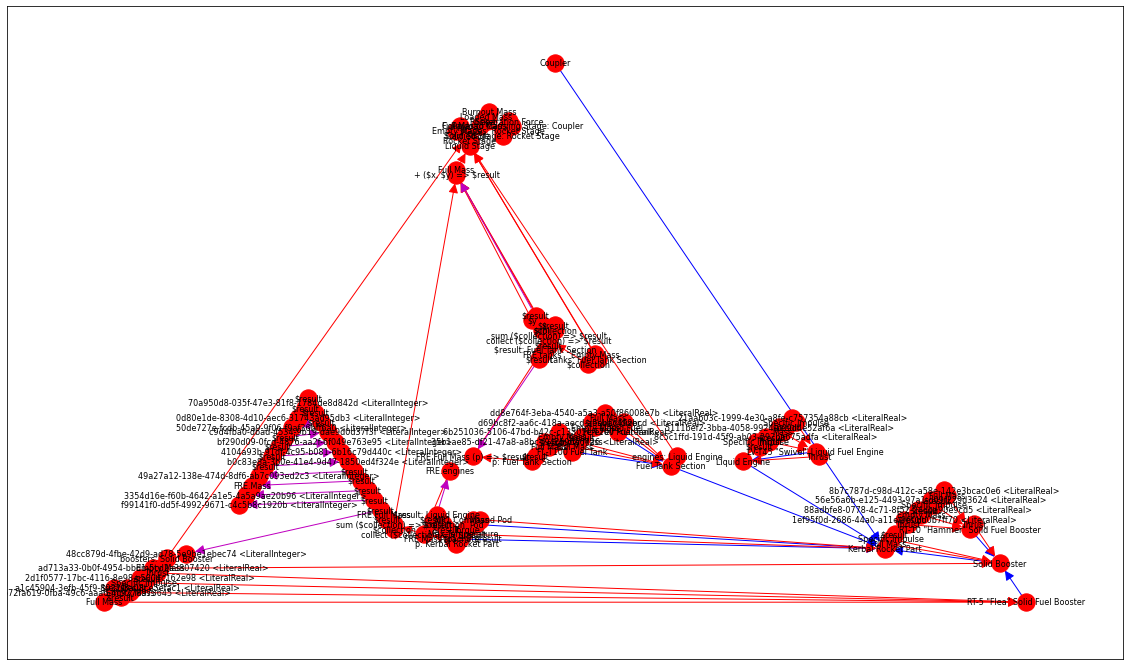

In [14]:
pos = NX.planar_layout(extended_banded_feature_graph)

plt.figure(figsize=(20, 12))
        
NX.draw_networkx_nodes(extended_banded_feature_graph, pos, nodelist=extended_banded_feature_graph.nodes, node_color="r")

node_labels = {}

for node in extended_banded_feature_graph.nodes:
    label = labeling.m1_signature(lpg.nodes[node], lpg.nodes).replace('$', '\$')
    node_labels.update({node: label})

sc_edges = []
fm_edges = []
ft_edges = []
pm_edges = []
rpm_edges = []

for edg in extended_banded_feature_graph.edges:
    if edg[2] == 'Superclassing':
        sc_edges.append([edg[0], edg[1]])
    elif edg[2] == 'FeatureMembership':
        fm_edges.append([edg[0], edg[1]])
    elif edg[2] == 'FeatureMembership':
        pm_edges.append([edg[0], edg[1]])
    elif edg[2] == 'ParameterMembership':
        fm_edges.append([edg[0], edg[1]])
    elif edg[2] == 'ReturnParameterMembership':
        rpm_edges.append([edg[0], edg[1]])
        
NX.draw_networkx_labels(extended_banded_feature_graph, pos, node_labels, font_size=8)
NX.draw_networkx_edges(extended_banded_feature_graph, pos, edgelist=sc_edges, edge_color="b", arrowsize=20)
NX.draw_networkx_edges(extended_banded_feature_graph, pos, edgelist=fm_edges, edge_color="r", arrowsize=20)
NX.draw_networkx_edges(extended_banded_feature_graph, pos, edgelist=ft_edges, edge_color="g", arrowsize=20)
NX.draw_networkx_edges(extended_banded_feature_graph, pos, edgelist=pm_edges, edge_color="c", arrowsize=20)
NX.draw_networkx_edges(extended_banded_feature_graph, pos, edgelist=rpm_edges, edge_color="m", arrowsize=20)
1

In [15]:
xes[0]['@id'] in list(extended_banded_feature_graph.nodes)

True

In [16]:
import pymbe.query.metamodel_navigator as MN

In [17]:
MN.feature_upper_multiplicity(
    client.elements_by_id['c9a16c71-4138-47b3-ae75-f5d0a525b633'],
    client
)

8

In [28]:
import pymbe.query.query as Query
Query.roll_up_upper_multiplicity(
    lpg,
    client.elements_by_id['069675af-a514-40e3-9010-605553dec7c9'],
    client
)

5

In [21]:
banded_roots = [node for node in extended_banded_feature_graph.nodes if extended_banded_feature_graph.out_degree(node) == 0]

In [26]:
for part_tree_root in banded_roots:
    try:
        part_path = NX.shortest_path(
            extended_banded_feature_graph,
            '069675af-a514-40e3-9010-605553dec7c9',
            part_tree_root)
    except NX.NetworkXNoPath:
        pass
    except NX.NodeNotFound:
        # nothing to roll up, so just use own multiplicity
        corrected_mult = feature_lower_multiplicity(feat, client)

The walk below shows how to get from parameters to the formulas calculating them or owning attribute usages.

In [27]:
[labeling.m1_signature(lpg.nodes[step], lpg.nodes) for step in part_path]

['$result',
 'FRE.Full Mass (p) => $result',
 'collect ($collection) => $result',
 'sum ($collection) => $result',
 '+ ($x, $y) => $result',
 'Full Mass',
 'Liquid Stage',
 'Rocket Stage',
 'stages: Rocket Stage',
 'Rocket']